<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2022-1/notebooks/3b_caltech101_transfer_loc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Localización empleando transferencia

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).

---
---

En esta libreta entrenaremos un modelo para localización de objetos en el conjunto [Caltech 101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) empleando trasferencia de conocimiento. Este ejemplo está basado en método presentado en [*OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks*](https://arxiv.org/abs/1312.6229) de 2014 por Sermanet et al. 

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/figs/iou.svg" width="950" height="750" />

## 1 Preparación

### 1.1 Bibliotecas

In [1]:
# Colab
! pip install torchinfo

In [2]:
# funciones aleatorias
import random
# sistema de archivos
import os
# flush!
import sys
# procesamiento xml
import xml.etree.ElementTree as ET
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
from scipy.io import loadmat
from torch.utils.data import DataLoader, random_split
# from torchvision.datasets import VisionDataset 
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import tqdm
# imágenes
from PIL import Image

### 1.2 Utilerias

In [3]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(rows, cols, xs, y_true, y_pred=None, 
                 y_true_color='b', y_pred_color='g', figsize=(14, 7)):
    """Despliega ejemplos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            img = xs[i]
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            x, y, w, h = y_true[i]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                                     edgecolor=y_true_color, 
                                     facecolor='none')
            ax[r, c].add_patch(rect)
            if y_pred is not None:
                img_h, img_w = img.shape[:2]
                x, y, w, h = y_pred[i]
                if x + w > img_w:
                    w = img_w - x
                if y + h > img_h:
                    h = img_h - y
                rect = patches.Rectangle((x, y), w, h, linewidth=1, 
                                         edgecolor=y_pred_color, 
                                         facecolor='none')
                ax[r, c].add_patch(rect)
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(rows, cols, x, y_true, y_pred=None, 
                  y_true_color='b', y_pred_color='g', figsize=(14, 7)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)

    y_true = y_true.numpy().astype(np.uint8)
    if y_pred is not None:
        y_pred = y_pred.numpy().astype(np.uint8)
    display_grid(rows, cols, x, y_true, y_pred, 
                 y_true_color=y_true_color,
                 y_pred_color=y_pred_color,
                 figsize=figsize)


def compute_iou(a, b):
    """Computa intersección sobre unión."""
    # obtenemos coordenadas
    xa1, ya1, wa, ha = a.T
    xa2, ya2 = xa1 + wa, ya1 + ha
    xb1, yb1, wb, hb = b.T
    xb2, yb2 = xb1 + wb, yb1 + hb
    # determinar las coordenadas (x, y) del rectangulo de intersección
    xa = torch.max(xa1, xb1)
    ya = torch.max(ya1, yb1)
    xb = torch.min(xa2, xb2)
    yb = torch.min(ya2, yb2)
    # computamos áreas
    area_a = wa * ha
    area_b = wb * hb
    # computamos intersección
    inter = torch.clamp(xb - xa + 1, min=0) * torch.clamp(yb - ya + 1, min=0)
    # computamos unión
    union = area_a + area_b - inter
    # computamos IOU
    iou = torch.mean(inter / union)
    return iou


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Conjunto de datos

In [4]:
# basado en https://github.com/pytorch/vision/blob/master/torchvision/datasets/caltech.py 
class Caltech101:

    def __init__(self, root, transform, download=False):
        self.root = join(root, 'caltech101')
        self.images_dir = join(self.root, '101_ObjectCategories')
        self.annotations_dir = join(self.root, 'Annotations')
        self.transform = transform
        os.makedirs(self.root, exist_ok=True)

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.' +
                ' You can use download=True to download it')

        # leemos categorias
        self.categories = sorted(os.listdir(self.images_dir))
        # this is not a real class
        self.categories.remove("BACKGROUND_Google")
        
        # For some reason, the category names in "101_ObjectCategories" and
        # "Annotations" do not always match. This is a manual map between the
        # two. Defaults to using same name, since most names are fine.
        name_map = {"Faces": "Faces_2",
                    "Faces_easy": "Faces_3",
                    "Motorbikes": "Motorbikes_16",
                    "airplanes": "Airplanes_Side_2"}
        self.annotation_categories = list(map(
            lambda x: name_map[x] if x in name_map else x, self.categories))


        self.index = []
        self.y = []
        for (i, c) in enumerate(self.categories):
            n = len(os.listdir(join(self.images_dir, c)))
            self.index.extend(range(1, n + 1))
            self.y.extend(n * [i])

    def __getitem__(self, index):
        img = Image.open(join(
            self.images_dir,                  
            self.categories[self.y[index]],
            "image_{:04d}.jpg".format(self.index[index]))
        )
        # si la imagen es escala de grises
        # transformamos a RGB
        if img.mode == 'L':
            rgbimg = Image.new('RGB', img.size)
            rgbimg.paste(img)
            img = rgbimg

        
        data = loadmat(join(
            self.annotations_dir,
            self.annotation_categories[self.y[index]],
            "annotation_{:04d}.mat".format(self.index[index]))
        )
        # [y1, y2, x1, x2]
        box = data["box_coord"][0]

        if self.transform is not None:
            img, box = self.transform(img, box)

        return img, box

    def __len__(self):
        return len(self.index)
    
    def _check_integrity(self):
        return os.path.exists(self.images_dir)

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/d7Z7oWMLfXBjCTX/download',
            download_root=self.root,
            filename='caltech101.tar.gz',
            md5='4362a24332bb2029214f0f640224eadc'
        )

### 2.2 Transformación

In [5]:
class Rescale:

    def __init__(self, size, img_tsfm):
        self.size = size
        self.img_tsfm = img_tsfm

    # hace el objeto llamable, 
    # se comporta como una una función
    def __call__(self, img, box):
        # obtenemos las dimensiones originales
        img_w, img_h = img.size
        img = self.img_tsfm(img)
        
        # calculamos escalas
        scale_x = img_w / self.size
        scale_y = img_h / self.size
        # escalamos el cuadro delimitador
        y1, y2, x1, x2 = box
        y1 = int(y1 / scale_y)
        y2 = int(y2 / scale_y)
        x1 = int(x1 / scale_x)
        x2 = int(x2 / scale_x)
        # calculamos ancho y alto
        w = x2 - x1
        h = y2 - y1
        # armamos cuadro delimitador
        box = [x1, y1, w, h]
        box = torch.tensor(box, dtype=torch.float32)
    
        return img, box

### 2.3 Instancia del conjunto y partición

In [6]:
# transofrmación de la imagen
img_tsfm = T.Compose([
    # redimensionamos a 224x224
    T.Resize([IMG_SIZE, IMG_SIZE]),
    # convertimos a torch.Tensor [3,H,W]
    # y escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])
# transformación conjunta del ejemplo
tsfm = Rescale(IMG_SIZE, img_tsfm)

ds = Caltech101(DATA_DIR, tsfm, download=True)

trn_size = int(0.8 * len(ds))
tst_size = len(ds) - trn_size
trn_ds, tst_ds = random_split(ds, [trn_size, tst_size])
len(trn_ds), len(tst_ds)

Files already downloaded and verified


(6941, 1736)

### 2.4 Cargadores de datos

In [7]:
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # 4 procesos paralelos
    num_workers=4
)

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32, 4]) dtype=torch.float32


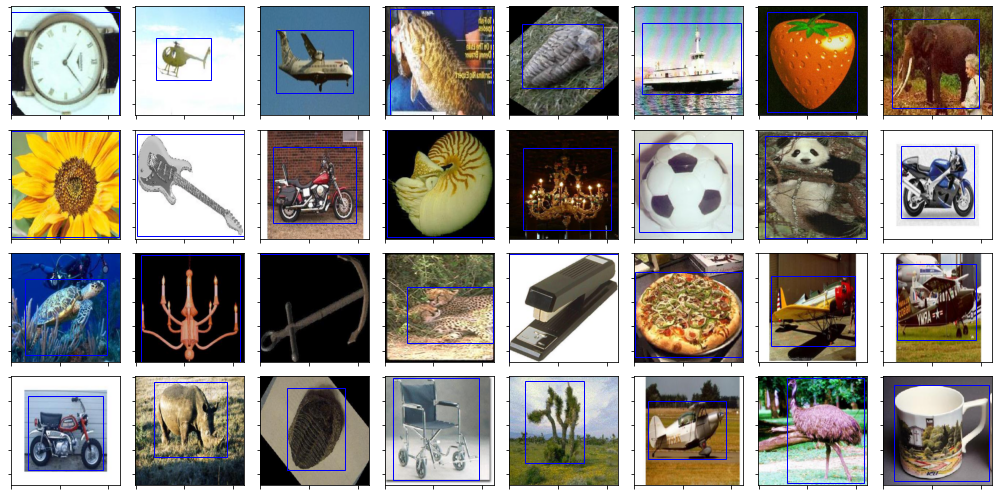

In [8]:
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(ROWS, COLS, x, y)

## 3 Modelo

Torchvision provee una familia de [modelos](https://pytorch.org/docs/1.6.0/torchvision/models.html#classification) preentrenados en ImageNet. Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes. 

In [9]:
tvm.shufflenet_v2_x0_5()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

### 3.1 Carga de pesos y transferencia

In [10]:
class ShufflenetV2Loc(nn.Module):
    
    def __init__(self, pretrained):
        super().__init__()

        # cargamos el modelo
        self.feats = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
        
        # remplazamos la FC para dejar intactas 
        # las características (puente o diablito)
        self.feats.fc = nn.Identity()

        # ensamblamos la etapa de regresión
        self.num_features = 1024
        self.reg = nn.Sequential(
            nn.BatchNorm1d(self.num_features),
            nn.Linear(self.num_features, 4)
        )

    def freeze_feats(self, freeze=True):
        requires_grad = not freeze
        for param in self.feats.parameters():
            param.requires_grad = requires_grad

    def unfreeze_feats(self):
        self.freeze_feats(False)

    def forward(self, x):
        # [N, 3, 224, 224] => [N, 1024]
        x = self.feats(x)
        # [N, 1024] => [N, 4]
        x = self.reg(x)
        return x


# instancimos modelo
model = ShufflenetV2Loc(True)
# congelado de parámetros de la CNN
model.freeze_feats()
# congelado de estadísticas de todo el modelo
_ = model.eval()

### 3.2 Inspección de la arquitectura

In [11]:
x = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 224, 224]) => torch.Size([1, 4])


/home/richardt/.miniconda3/envs/cap/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
summary(model, (1, 3, IMG_SIZE, IMG_SIZE),
        device='cpu', verbose=0)

Layer (type:depth-idx)                        Output Shape              Param #
ShufflenetV2Loc                               --                        --
├─ShuffleNetV2: 1-1                           [1, 1024]                 --
│    └─Sequential: 2-1                        [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                       [1, 24, 112, 112]         (648)
│    │    └─BatchNorm2d: 3-2                  [1, 24, 112, 112]         (48)
│    │    └─ReLU: 3-3                         [1, 24, 112, 112]         --
│    └─MaxPool2d: 2-2                         [1, 24, 56, 56]           --
│    └─Sequential: 2-3                        [1, 48, 28, 28]           --
│    │    └─InvertedResidual: 3-4             [1, 48, 28, 28]           (2,400)
│    │    └─InvertedResidual: 3-5             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-6             [1, 48, 28, 28]           (1,512)
│    │    └─InvertedResidual: 3-7             [1, 48, 28, 28]           (1,

## 4 Entrenamiento

<!-- <img src="../figs/comida_entrenamiento.svg" width="650" height="450"> -->

In [13]:
!nvidia-smi

Sun Oct 10 16:36:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   59C    P0    25W /  N/A |    200MiB /  6078MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# obtenemos dispositivo en GPU, si no en CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
# movemos el modelo 
model = model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

### 4.1 Ciclo de entrenamiento

In [16]:
def train_epoch(dl, model, opt, device, epoch):
    for x, y_true in tqdm(dl, desc=f'E{epoch:2d} Train'):
        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)
        # computamos la predicción
        y_pred = model(x)
        # computamos la pérdida
        loss = F.mse_loss(y_pred, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, epoch):
    mses, ious = [], []
    # evitamos que se registren las operaciones 
        # en la gráfica de cómputo
    with torch.no_grad():
        # evaluación de la época
        for x, y_true in tqdm(dl, desc=f'E{epoch:2d} Test '):
            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)
            # computamos la predicción
            y_pred = model(x)
            # computamos la pérdida
            mse = F.mse_loss(y_pred, y_true)
            # computamos la IOU
            iou = compute_iou(y_pred, y_true)
            # guardamos históricos
            mses.append(mse.item())
            ious.append(iou.item() * 100)
    # promediamos métricas
    mse = np.mean(mses)
    iou = np.mean(ious)
    return mse, iou


def train(model, trn_dl, val_dl, 
          lr=1e-2, epochs=2, full_train=False):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # optimizador
    opt = optim.Adam(model.parameters(), lr)
    
    # para el entrenamiento de la red completa
    # descongelamos parametros de la cnn
    model.freeze_feats(not full_train)
    
    # ponemos el modelo completo en modo de evaluación
    model.eval()

    # ciclo de entrenamiento
    for epoch in range(epochs):

        # modelo en modo de entrenamiento
        model.train()

        # entrenamiento de la época
        train_epoch(trn_dl, model, opt, device, epoch)      

        # modelo en modo de evaluación
        model.eval()

        # evaluación de la época
        mse, iou = eval_epoch(val_dl, model, device, epoch)

        # imprimimos métricas
        print(f'E{epoch:2} mse={mse:7.2f} iou={iou:4.2f}')
        sys.stdout.flush()

In [17]:
# entrenando solo la etapa de regresión
train(model, trn_dl, tst_dl, full_train=False)

E 0 Train:   0%|          | 0/217 [00:00<?, ?it/s]

E 0 Test :   0%|          | 0/55 [00:00<?, ?it/s]

E 0 mse= 519.57 iou=75.10


E 1 Train:   0%|          | 0/217 [00:00<?, ?it/s]

E 1 Test :   0%|          | 0/55 [00:00<?, ?it/s]

E 1 mse= 488.57 iou=75.55


## 5. Probando

In [18]:
model = model.to('cpu').eval()

### 5.1 Evaluando en entrenamiento

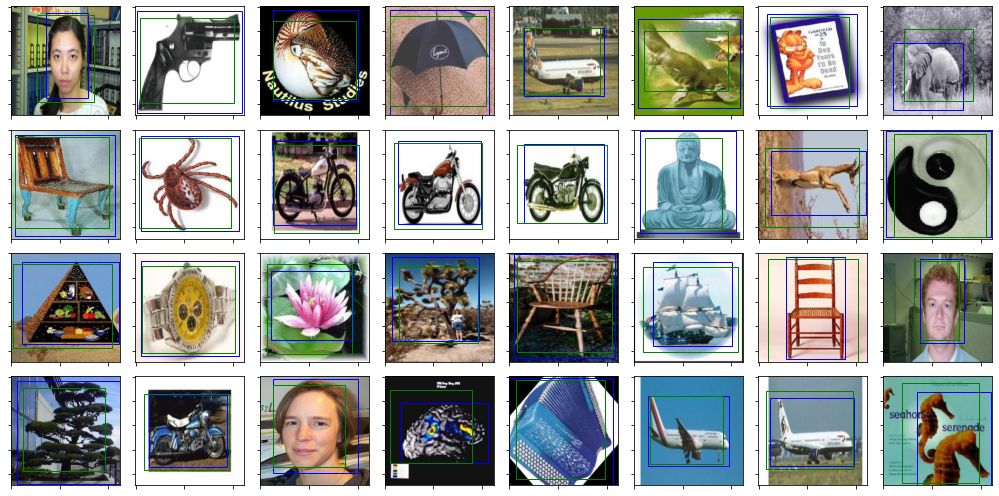

In [19]:
with torch.no_grad():
    x, y_true = next(iter(trn_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

### 5.2 Evaluando en prueba

/tmp/ipykernel_68621/4070413504.py:36: RuntimeWarning: overflow encountered in ubyte_scalars
  if x + w > img_w:
/home/richardt/.miniconda3/envs/cap/lib/python3.8/site-packages/matplotlib/patches.py:768: RuntimeWarning: overflow encountered in ubyte_scalars
  x1 = self.convert_xunits(self._x0 + self._width)


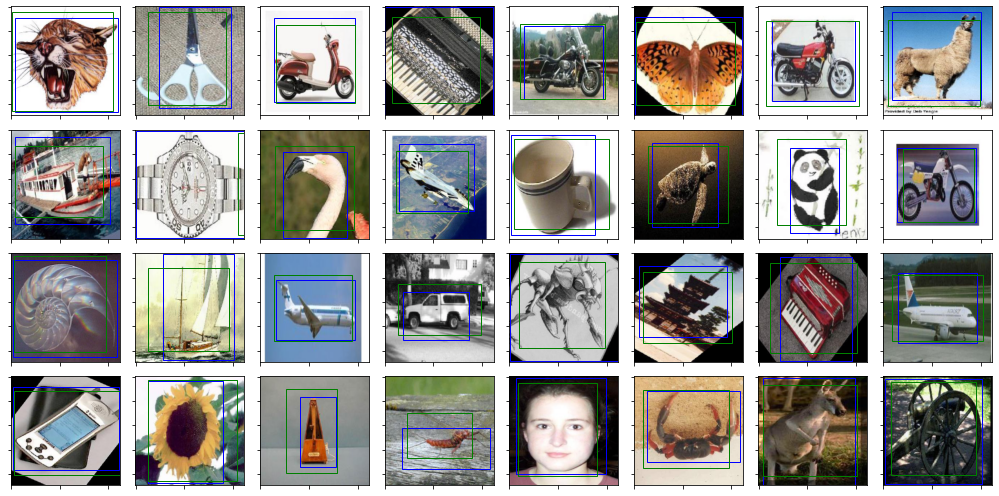

In [20]:
with torch.no_grad():
    x, y_true = next(iter(tst_dl))
    y_pred = model(x)
    display_batch(ROWS, COLS, x, y_true, y_pred)

## 6. Participación 1

Remplaza el modelo preentranado por una arquitectura [MobileNetV2](https://pytorch.org/docs/1.6.0/torchvision/models.html#mobilenet-v2) y después por una [DenseNet121](https://pytorch.org/docs/1.6.0/torchvision/models.html#id16).

## 7. Participación 2

Realiza transferencia de conocimiento reentrenando el modelo completo. ¿Qué pasa con el desempeño y la tasa de aprendizaje?